<a href="https://colab.research.google.com/github/KenjiNakagawa/RL-public/blob/master/DQNSimple2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [173]:
import os
import numpy as np
from collections import deque
# import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib.animation as animation
import matplotlib.pyplot as plt


class CatchBall:
    def __init__(self):
        # parameters
#         self.name = os.path.splitext(os.path.basename(__file__))[0]
        self.name = "Env"
        # self.screen_n_rows = 3
        self.screen = np.zeros((3, 3))
        # self.player_length = 3
        self.enable_actions = (0, 1, 2,3,4,5,6,7,8)
        self.frame_rate = 10

        # variables
        self.reset()

    def update(self, action):
        """
        action:
            0: do nothing
            1: move left
            2: move right
        """
        # self.reward = 0
        self.reward -= 1
        next_turn = True
        # update player position
        if action == self.enable_actions[0]: 
          if self.screen[0,0] > 0:
            next_turn = False
          else:
            self.screen[0,0] = 1
        elif action == self.enable_actions[1]:
          if self.screen[0,1] > 0:
            next_turn = False
          else:
            self.screen[0,1] = 1
        elif action == self.enable_actions[2]:
          if self.screen[0,2] > 0:
            next_turn = False
          else:
            self.screen[0,2] = 1
        elif action == self.enable_actions[3]:
          if self.screen[1,0] > 0:
            next_turn = False
          else:
            self.screen[1,0] = 1
        elif action == self.enable_actions[4]:
          if self.screen[1,1] > 0:
            next_turn = False
          else:
            self.screen[1,1] = 1
        elif action == self.enable_actions[5]:
          if self.screen[1,2] > 0:
            next_turn = False
          else:
            self.screen[1,2] = 1
        elif action == self.enable_actions[6]:
          if self.screen[2,0] > 0:
            next_turn = False
          else:
            self.screen[2,0] = 1
        elif action == self.enable_actions[7]:
          if self.screen[2,1] > 0:
            next_turn = False
          else:
            self.screen[2,1] = 1
        elif action == self.enable_actions[8]:
          if self.screen[2,2] > 0:
            next_turn = False
          else:
            self.screen[2,2] = 1
        
        if next_turn == True:
          for i in range(3):
            for j in range(3):
              if self.screen[i,j] == 0:
                self.screen[i,j] = 4
                break
            else:
              continue
            break


        # collision detection

        self.terminal = False
        if self.screen.min() == 1:
          self.terminal = True
        
        if self.screen[0,:].sum() == 3:
          self.reward += 100
          self.terminal = True
        elif self.screen[1,:].sum() == 3:
          self.reward += 100
          self.terminal = True
        elif self.screen[2,:].sum() == 3:
          self.reward += 100
          self.terminal = True
        elif self.screen[:,0].sum() == 3:
          self.reward += 100
          self.terminal = True
        elif self.screen[:,1].sum() == 3:
          self.reward += 100
          self.terminal = True
        elif self.screen[:,2].sum() == 3:
          self.reward += 100
          self.terminal = True

        if self.screen[0,:].sum() == 12:
          self.reward += -100
          self.terminal = True
        elif self.screen[1,:].sum() == 12:
          self.reward += -100
          self.terminal = True
        elif self.screen[2,:].sum() == 12:
          self.reward += -100
          self.terminal = True
        elif self.screen[:,0].sum() == 12:
          self.reward += -100
          self.terminal = True
        elif self.screen[:,1].sum() == 12:
          self.reward += -100
          self.terminal = True
        elif self.screen[:,2].sum() == 12:
          self.reward += -100
          self.terminal = True

        if self.terminal == True:
          print(self.screen)

    def observe(self):
        # self.draw()
        return self.screen, self.reward, self.terminal

    def execute_action(self, action):
        self.update(action)

    def reset(self):
        # reset player position
        # self.player_row = self.screen_n_rows - 1
        # self.player_col = np.random.randint(self.screen_n_cols - self.player_length)
        self.screen = np.zeros((3, 3))
        # reset ball position
        # self.ball_row = 0
        # self.ball_col = np.random.randint(self.screen_n_cols)

        # reset other variables
        self.reward = 9
        self.terminal = False


In [134]:
screen =  np.zeros((3, 3))
screen[1,1] = 1
screen[1,:].sum()

1.0

In [110]:
class DQNAgent:
    """
    Multi Layer Perceptron with Experience Replay
    """

    def __init__(self, enable_actions, environment_name):
        # parameters
#         self.name = os.path.splitext(os.path.basename(__file__))[0]
        self.name = "Agent"
        self.environment_name = environment_name
        self.enable_actions = enable_actions
        self.n_actions = len(self.enable_actions)
        self.minibatch_size = 32
        self.replay_memory_size = 2000
        self.learning_rate = 0.001
        self.discount_factor = 0.99
        self.exploration = 0.2
        self.model_dir = "models"
        self.model_name = "{}.ckpt".format(self.environment_name)

        # replay memory
        self.D = deque(maxlen=self.replay_memory_size)

        # model
        self.init_model()

        # variables
        self.current_loss = 0.0

    def init_model(self):
        tf.compat.v1.disable_eager_execution()

        # input layer (8 x 8)
        self.x = tf.compat.v1.placeholder(tf.float32, [None, 3, 3])
        
        # flatten
        x_flat = tf.reshape(self.x, [-1, 9])

        # fully connected layer 
        W_fc1 = tf.Variable(tf.truncated_normal([9, 9], stddev=0.01))
        b_fc1 = tf.Variable(tf.zeros([9]))
        h_fc1 = tf.nn.relu(tf.matmul(x_flat, W_fc1) + b_fc1)

        # output layer (n_actions)
        W_out = tf.Variable(tf.truncated_normal([9, self.n_actions], stddev=0.01))
        b_out = tf.Variable(tf.zeros([self.n_actions]))
        self.y = tf.matmul(h_fc1, W_out) + b_out

        # loss function
        self.y_ = tf.compat.v1.placeholder(tf.float32, [None, self.n_actions])
        self.loss = tf.reduce_mean(tf.square(self.y_ - self.y))

        # train operation
        optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
        self.training = optimizer.minimize(self.loss)

        # saver
        self.saver = tf.train.Saver()

        # session
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())

    def Q_values(self, state):
        # Q(state, action) of all actions
        return self.sess.run(self.y, feed_dict={self.x: [state]})[0]

    def select_action(self, state, epsilon):
        if np.random.rand() <= epsilon:
            # random
            return np.random.choice(self.enable_actions)
        else:
            # max_action Q(state, action)
            return self.enable_actions[np.argmax(self.Q_values(state))]

    def store_experience(self, state, action, reward, state_1, terminal):
        self.D.append((state, action, reward, state_1, terminal))

    def experience_replay(self):
        state_minibatch = []
        y_minibatch = []

        # sample random minibatch
        minibatch_size = min(len(self.D), self.minibatch_size)
        minibatch_indexes = np.random.randint(0, len(self.D), minibatch_size)

        for j in minibatch_indexes:
            state_j, action_j, reward_j, state_j_1, terminal = self.D[j]
            action_j_index = self.enable_actions.index(action_j)

            y_j = self.Q_values(state_j)

            if terminal:
                y_j[action_j_index] = reward_j
            else:
                # reward_j + gamma * max_action' Q(state', action')
                y_j[action_j_index] = reward_j + self.discount_factor * np.max(self.Q_values(state_j_1))  # NOQA

            state_minibatch.append(state_j)
            y_minibatch.append(y_j)

        # training
        self.sess.run(self.training, feed_dict={self.x: state_minibatch, self.y_: y_minibatch})

        # for log
        self.current_loss = self.sess.run(self.loss, feed_dict={self.x: state_minibatch, self.y_: y_minibatch})

    def load_model(self, model_path=None):
        if model_path:
            # load from model_path
            self.saver.restore(self.sess, model_path)
        else:
            # load from checkpoint
            checkpoint = tf.train.get_checkpoint_state(self.model_dir)
            if checkpoint and checkpoint.model_checkpoint_path:
                self.saver.restore(self.sess, checkpoint.model_checkpoint_path)

    def save_model(self):
        self.saver.save(self.sess, os.path.join(self.model_dir, self.model_name))


In [177]:
if __name__ == "__main__":
    # parameters
    n_epochs = 400

    # environment, agent
    env = CatchBall()
    agent = DQNAgent(env.enable_actions, env.name)

    # variables
    win = 0

    for e in range(n_epochs):
        # reset
        frame = 0
        loss = 0.0
        Q_max = 0.0
        env.reset()
        state_t_1, reward_t, terminal = env.observe()

        while not terminal:
            state_t = state_t_1

            # execute action in environment
            action_t = agent.select_action(state_t, agent.exploration)
            env.execute_action(action_t)

            # observe environment
            state_t_1, reward_t, terminal = env.observe()

            # store experience
            agent.store_experience(state_t, action_t, reward_t, state_t_1, terminal)

            # experience replay
            agent.experience_replay()

            # for log
            frame += 1
            loss += agent.current_loss
            Q_max += np.max(agent.Q_values(state_t))
            # if reward_t == 1:
            #     win += 1

        print("EPOCH: {:03d}/{:03d} | RWD: {:03d} | LOSS: {:.4f} | Q_MAX: {:.4f}".format(
            e, n_epochs - 1, reward_t, loss / frame, Q_max / frame))

    # save model
    agent.save_model()

[[1. 4. 4.]
 [4. 4. 1.]
 [1. 1. 1.]]
EPOCH: 000/399 | RWD: 070 | LOSS: 9.1795 | Q_MAX: 0.0052
[[4. 4. 1.]
 [1. 4. 4.]
 [1. 1. 1.]]
EPOCH: 001/399 | RWD: 048 | LOSS: 37.9610 | Q_MAX: -0.0086
[[4. 4. 4.]
 [0. 0. 0.]
 [1. 1. 1.]]
EPOCH: 002/399 | RWD: 004 | LOSS: 85.0605 | Q_MAX: -0.0805
[[4. 4. 4.]
 [0. 1. 0.]
 [0. 1. 1.]]
EPOCH: 003/399 | RWD: -113 | LOSS: 58.7980 | Q_MAX: -0.0945
[[4. 4. 1.]
 [4. 1. 1.]
 [4. 1. 0.]]
EPOCH: 004/399 | RWD: -116 | LOSS: 62.4988 | Q_MAX: -0.0720
[[4. 4. 1.]
 [4. 1. 4.]
 [1. 1. 1.]]
EPOCH: 005/399 | RWD: 078 | LOSS: 55.2156 | Q_MAX: -0.1308
[[4. 4. 4.]
 [1. 0. 0.]
 [1. 1. 0.]]
EPOCH: 006/399 | RWD: -99 | LOSS: 56.0426 | Q_MAX: -0.1672
[[4. 4. 4.]
 [1. 0. 0.]
 [1. 1. 0.]]
EPOCH: 007/399 | RWD: -101 | LOSS: 59.8345 | Q_MAX: -0.1955
[[4. 4. 4.]
 [0. 1. 0.]
 [1. 1. 0.]]
EPOCH: 008/399 | RWD: -100 | LOSS: 53.3397 | Q_MAX: -0.2343
[[4. 4. 4.]
 [1. 0. 0.]
 [0. 1. 1.]]
EPOCH: 009/399 | RWD: -107 | LOSS: 73.4877 | Q_MAX: -0.3067
[[1. 4. 4.]
 [1. 4. 1.]
 [4. 1. 1.]]


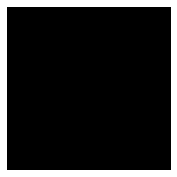

In [176]:
def init():
    img.set_array(state_t_1)
    plt.axis("off")
    return img,


def animate(step):
    global win, lose
    global state_t_1, reward_t, terminal

    if terminal:
        env.reset()
        print("RWD:",reward_t)
        # print("WIN: {:03d}/{:03d} ({:.1f}%)".format(win, win + lose, 100 * win / (win + lose)))

    else:
        state_t = state_t_1

        # execute action in environment
        action_t = agent.select_action(state_t, 0.0)
        env.execute_action(action_t)

    # observe environment
    state_t_1, reward_t, terminal = env.observe()

    # animate
    img.set_array(state_t_1)
    plt.axis("off")
    return img,

env = CatchBall()
# variables
win, lose = 0, 0
state_t_1, reward_t, terminal = env.observe()

# animate
fig = plt.figure(figsize=(3, 3))
fig.canvas.set_window_title("{}-{}".format(env.name, agent.name))
img = plt.imshow(state_t_1, interpolation="none", cmap="gray")
ani = animation.FuncAnimation(fig, animate, init_func=init, interval=(100 / env.frame_rate),frames=200, blit=True)

w = animation.PillowWriter(fps=20)
ani.save('animation_test.gif', writer=w)